# ターボファンエンジンの診断システム構築

## 目的
- ターボファンエンジンの診断システムを構築する
    - システムの機能：
        - エンジンの現状把握（センサーデータの可視化）
        - 故障までのデータがない場合、異常検知手法も用いてエンジンの状態警告モデル
        - 故障までのデータがある場合、エンジンの状態を分類するモデル
        - 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル

## このノートブックの目的
- 故障までのデータがある場合、エンジンの残存耐用期間（RUL）予測モデル
    - RUL予測のベースラインモデル（回帰モデル）を構築する

## インポート

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os
import gc
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

In [4]:
# pandasの設定
pd.set_option('display.max_columns',  50)
pd.set_option('display.max_rows', 100)

# 図の設定
mpl.rc('axes', titlesize=18)
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('xtick', direction='in')
mpl.rc('ytick', direction='in')
mpl.rc('legend', fontsize=16)

# 色の設定
from cycler import cycler
import matplotlib.colors as mcolors
colors = mcolors.TABLEAU_COLORS
mpl.rcParams['axes.prop_cycle']  = cycler(color = [c for c in colors.values()])

## Read data

In [5]:
# data path
data_dir = Path("../data/CMaps")
train_raw_dir = data_dir / "train_FD001.txt"
test_raw_dir = data_dir / "test_FD001.txt"
rul_raw_dir = data_dir / "RUL_FD001.txt"

In [6]:
# adding columns' name
variable_names = ['Unit','Time', 'setting_1', 'setting_2', 'setting_3',
                  'FanInletTemp', 'LPCOutletTemp', 'HPCOutletTemp', 
                  'LPTOutletTemp', 'FanInletPres', 'BypassDuctPres', 'TotalHPCOutletPres','PhysFanSpeed','PhysCoreSpeed', 
                  'EnginePresRatio', 'StaticHPCOutletPres', 'FuelFlowRatio', 'CorrFanSpeed', 'CorrCoreSpeed', 'BypassRatio',
                  'BurnerFuelAirRatio', 'BleedEnthalpy', 'DemandFanSpeed', 'DemandCorrFanSpeed', 'HPTCoolantBleed', 'LPTCoolantBleed']

In [7]:
# columns' group
index_names = ['Unit', 'Time']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = variable_names[5:]

In [8]:
train_df = pd.read_csv(train_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
train = train_df.copy()

test_df = pd.read_csv(test_raw_dir, 
                    sep='\s+', 
                    header=None,
                    index_col=False,
                    names=variable_names)
test = test_df.copy()

y_test = pd.read_csv(rul_raw_dir, 
                     sep='\s+', 
                     header=None,
                     index_col=False,
                     names=['RUL'])

In [9]:
train.head()

,Unit,Time,setting_1,setting_2,setting_3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,BypassDuctPres,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,EnginePresRatio,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 基礎集計確認

In [10]:
# inspect engine unit and time cycles
train[index_names].describe().T

,count,mean,std,min,25%,50%,75%,max
Unit,20631.0,51.506568,29.227633,1.0,26.0,52.0,77.0,100.0
Time,20631.0,108.807862,68.880990,1.0,52.0,104.0,156.0,362.0


In [11]:
# inspect time cycles
train[index_names].groupby('Unit').max().describe().T

,count,mean,std,min,25%,50%,75%,max
Time,100.0,206.31,46.342749,128.0,177.0,199.0,229.25,362.0


In [12]:
# inspect settings
train[setting_names].describe().T

,count,mean,std,min,25%,50%,75%,max
setting_1,20631.0,-0.000009,0.002187,-0.0087,-0.0015,0.0,0.0015,0.0087
setting_2,20631.0,0.000002,0.000293,-0.0006,-0.0002,0.0,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000,100.0000,100.0000,100.0,100.0000,100.0000


In [13]:
# sensor values
train[sensor_names].describe().T

,count,mean,std,min,25%,50%,75%,max
FanInletTemp,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
LPCOutletTemp,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
HPCOutletTemp,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
LPTOutletTemp,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
FanInletPres,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
BypassDuctPres,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
TotalHPCOutletPres,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
PhysFanSpeed,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
PhysCoreSpeed,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
EnginePresRatio,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


In [14]:
# add the sensor index with corresponding sensor name
sensor_index = [f"s_{i}" for i in range(1,22)]
sensor_dict = {key: value for key, value in zip(sensor_index, sensor_names)}

In [15]:
sensor_dict

{'s_1': 'FanInletTemp',
 's_2': 'LPCOutletTemp',
 's_3': 'HPCOutletTemp',
 's_4': 'LPTOutletTemp',
 's_5': 'FanInletPres',
 's_6': 'BypassDuctPres',
 's_7': 'TotalHPCOutletPres',
 's_8': 'PhysFanSpeed',
 's_9': 'PhysCoreSpeed',
 's_10': 'EnginePresRatio',
 's_11': 'StaticHPCOutletPres',
 's_12': 'FuelFlowRatio',
 's_13': 'CorrFanSpeed',
 's_14': 'CorrCoreSpeed',
 's_15': 'BypassRatio',
 's_16': 'BurnerFuelAirRatio',
 's_17': 'BleedEnthalpy',
 's_18': 'DemandFanSpeed',
 's_19': 'DemandCorrFanSpeed',
 's_20': 'HPTCoolantBleed',
 's_21': 'LPTCoolantBleed'}

## Add RUL values

In [16]:
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="Unit")
    max_cycle = grouped_by_unit["Time"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='Unit', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["Time"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,Unit,Time,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [17]:
train["RUL_piecewise"] = np.where(train["RUL"] > 125, 125, train["RUL"])

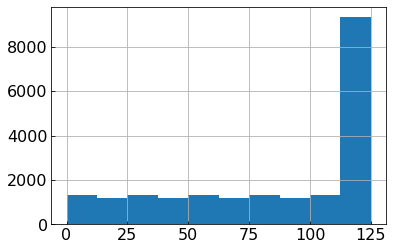

In [18]:
train["RUL_piecewise"].hist();

3407

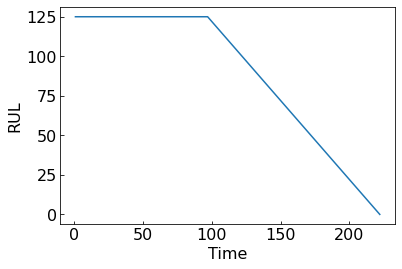

In [19]:
engine_unit = 10
_tmp = train.query("Unit == @engine_unit")[["RUL_piecewise","Time"]]
plt.plot("Time", "RUL_piecewise", data=_tmp)
plt.xlabel("Time")
plt.ylabel("RUL");

del _tmp
gc.collect()

In [20]:
def plot_sensor(sensor_name, sensor_dic, df):
    fig, ax = plt.subplots(figsize=(10,3))
    for i in df['Unit'].unique():
        if i % 10 == 0:
            ax.plot('RUL', sensor_name, data = df[df['Unit'] == i])
            ax.set_xlim([250,0])
    ax.set_title(f"{sensor_dic[sensor_name]}")
    ax.set_ylabel(sensor_name)
    ax.set_xlabel('Remaining Useful Life')

In [21]:
sensor_dic_rev = {key:value for value, key in sensor_dict.items()}

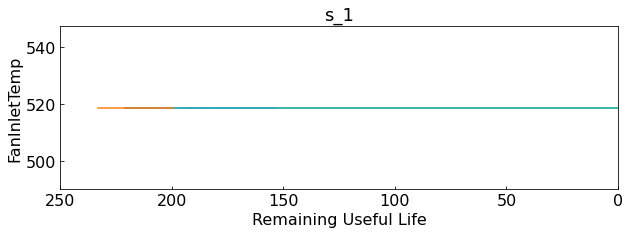

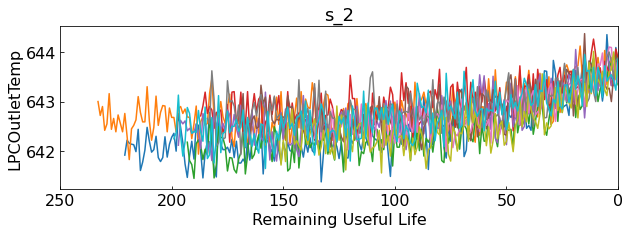

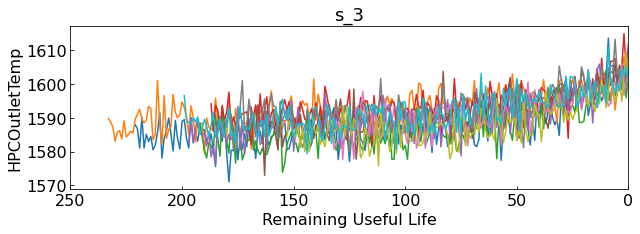

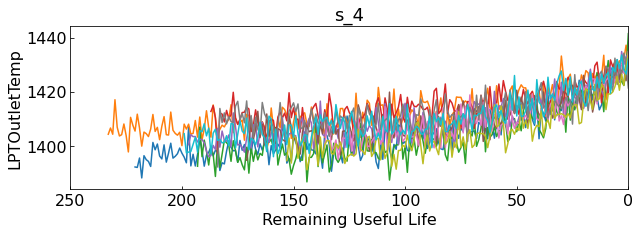

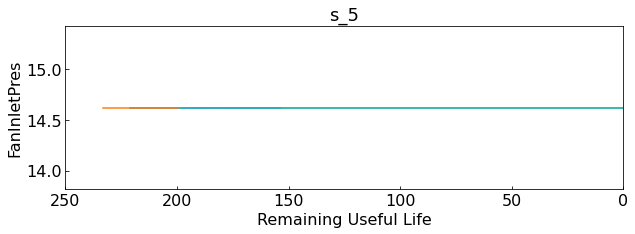

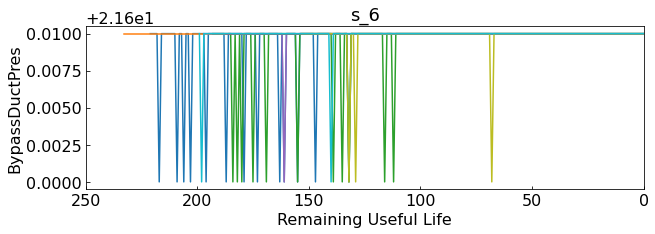

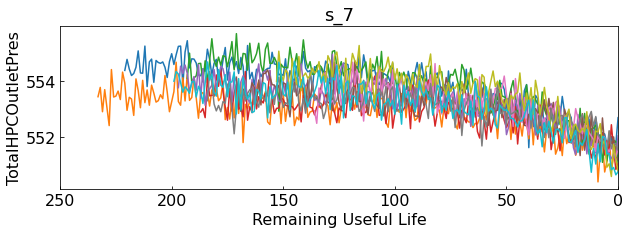

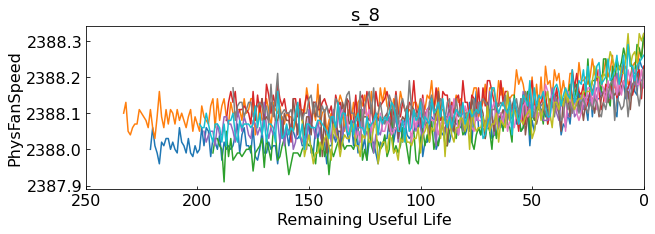

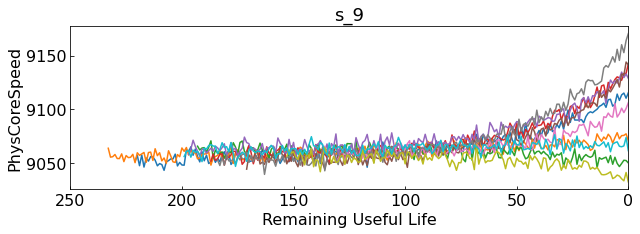

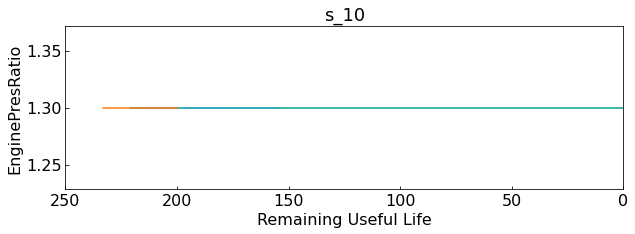

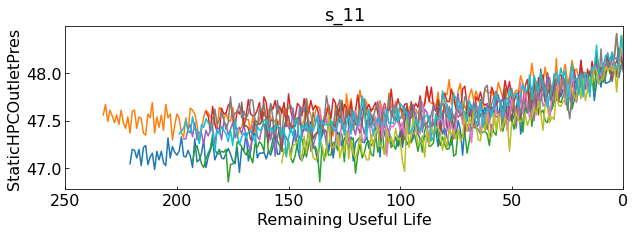

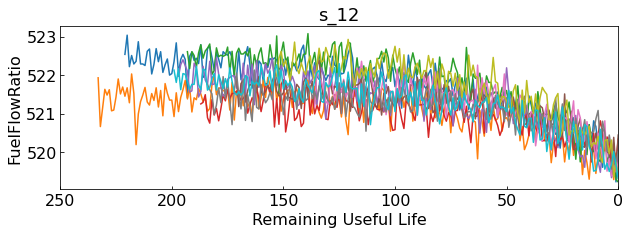

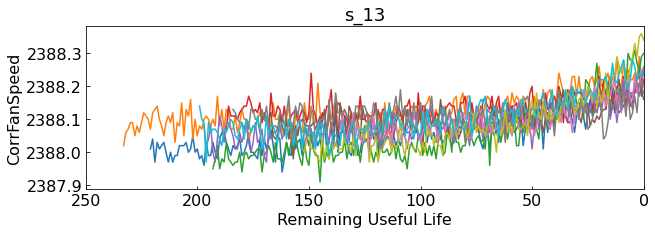

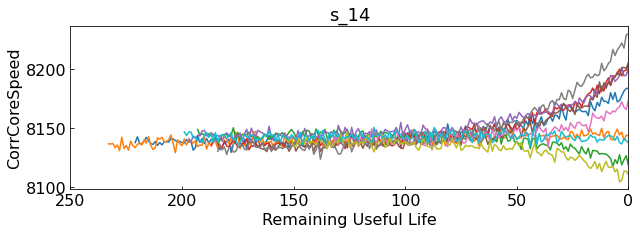

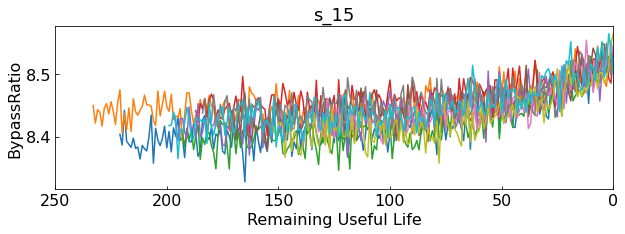

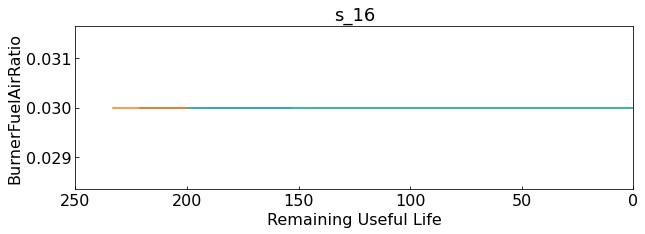

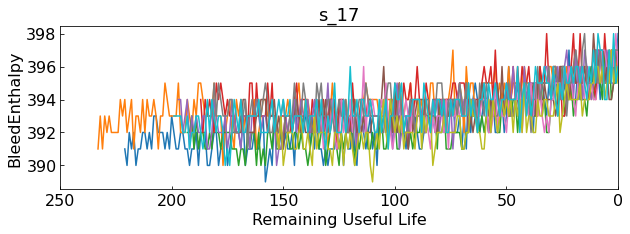

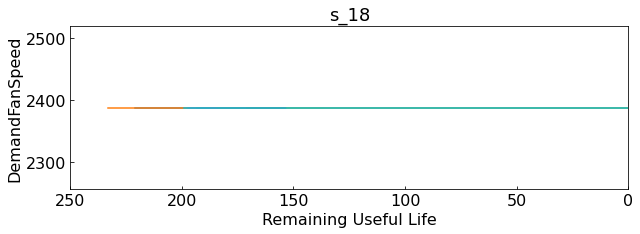

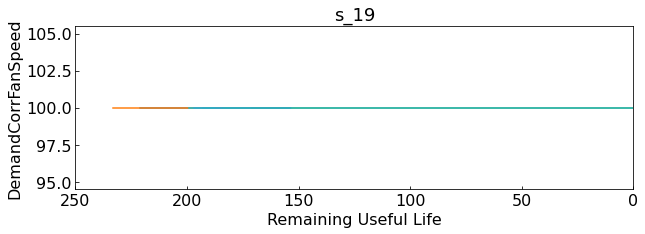

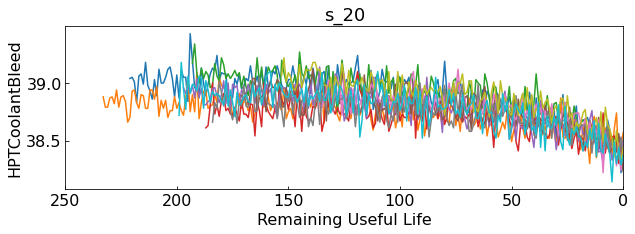

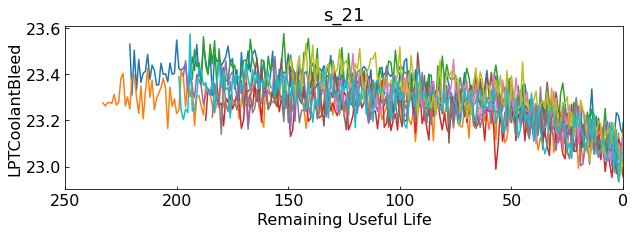

In [22]:
for index, sensor_name in enumerate(sensor_names):
    plot_sensor(sensor_name, sensor_dic_rev, train)

## Drop un-needed columns

In [23]:
# prep data
# drop unwanted columns and split target variable from training set
drop_sensors_index = [0, 4, 5, 9, 15, 17, 18]
drop_sensors = [sensor_names[i] for i in range(0,21) if i in drop_sensors_index]

In [24]:
drop_labels = index_names + setting_names + drop_sensors
print(drop_labels)

['Unit', 'Time', 'setting_1', 'setting_2', 'setting_3', 'FanInletTemp', 'FanInletPres', 'BypassDuctPres', 'EnginePresRatio', 'BurnerFuelAirRatio', 'DemandFanSpeed', 'DemandCorrFanSpeed']


## Base line model

In [25]:
selected_sensors = [sensor for sensor in sensor_names if sensor not in drop_sensors]

In [26]:
len(selected_sensors)

14

In [27]:
X_train = train[setting_names + selected_sensors].copy()
y_train = train['RUL_piecewise'].copy()

X_test = test.groupby('Unit').last().reset_index() # get last row of each engine
X_test = X_test[setting_names + selected_sensors]

In [28]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [29]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [30]:
# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

# on test set
y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.490811812910014, R2:0.7340484073765174
test set RMSE:21.910795523053643, R2:0.7219923493626457


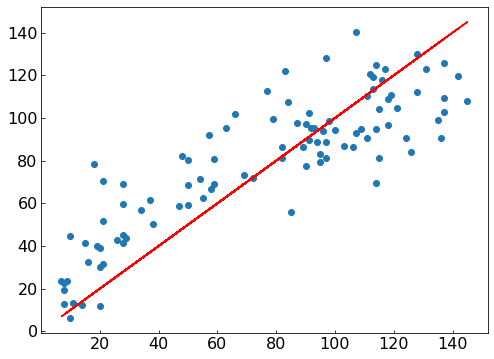

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_hat_test, label="Prediction")
plt.plot(y_test, y_test, 'r-', label="True")
plt.show()

In [32]:
train["RUL_predicted"] = y_hat_train

In [33]:
def plot_unit_id(data, id=82):
    unit_data = data.query("Unit == @id")
    plt.plot("Time", "RUL_piecewise", data=unit_data, color='r', linewidth=2)
    plt.plot("Time", "RUL_predicted", "--o", data=unit_data, markersize=5)
    plt.xlabel("Time")
    plt.ylabel("RUL")

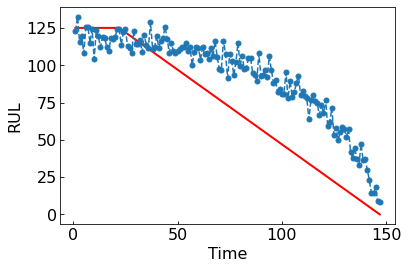

In [34]:
plot_unit_id(train.query("RUL_predicted > 0"), id=24)

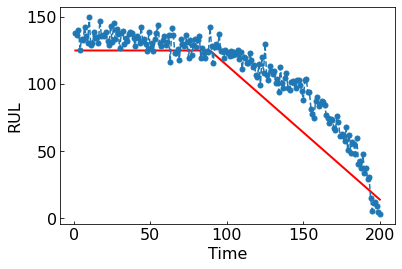

In [35]:
plot_unit_id(train.query("RUL_predicted > 0"), id=82)

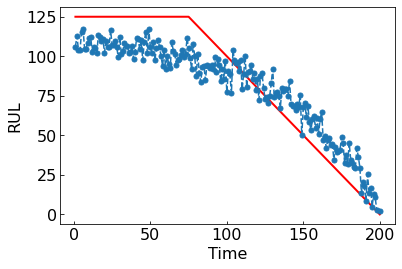

In [36]:
plot_unit_id(train.query("RUL_predicted > 0"), id=100)

80133

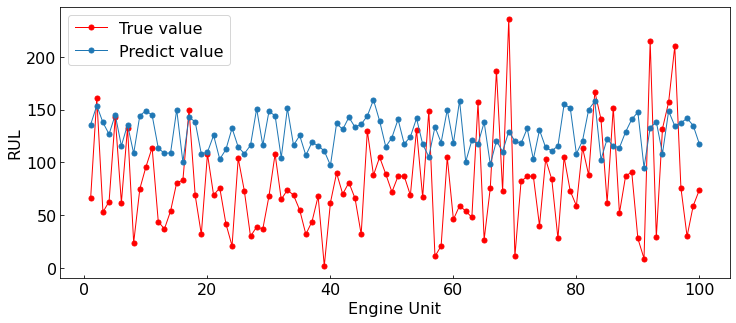

In [37]:
_tmp = train.groupby("Unit").max()
_tmp["New_RUL"] = _tmp["RUL"] - 125

plt.figure(figsize=(12, 5))
plt.plot(_tmp.index, _tmp["New_RUL"], '-ro',ms=5, lw=1, label="True value")
plt.plot(_tmp.index, _tmp["RUL_predicted"], '-o', ms=5, lw=1, label="Predict value")
plt.xlabel("Engine Unit")
plt.ylabel("RUL")
plt.legend();

del _tmp
gc.collect()